This notebook is also here: https://www.kaggle.com/code/fbereilh/prj-nlp-yahoo

## Intro

>You are tasked with sourcing an open dataset related to textual data and using it to address a problem of your choice within the realm of NLP, IR, Gen AI, or Semantic Search. The focus can be on tasks such as text classification, summarization, topic modeling, question answering, media recommendations, or semantic search.

One of the most challenging aspects of working with open problems is defining a clear and tractable problem statement. Given the limited time available, I have selected text classification as the focus. This task is generally more straightforward to frame, requires less preprocessing and infrastructure compared to more complex tasks such as question answering or semantic search, and benefits from the wide availability of labeled datasets.

Furthermore, the goal is to train a model so the chosen dataset should contain between 30,000 and 500,000 data points. This range ensures a sufficient volume of data for effective training without incurring heavy computational costs.

<br>
Possible options are:

| Dataset Name                  | Avg. Text Length         | Samples   | Classes | Domain              | Strengths                                                     | Weaknesses                                                 | Link                                                                                         |
| ----------------------------- | ------------------------ | --------- | ------- | ------------------- | ------------------------------------------------------------- | ---------------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **Amazon Reviews (Polarity)** | Medium (\~100–200 words) | \~400,000 | 2       | E-commerce          | High volume, structured, clear sentiment polarity             | Only binary classification; limited nuance                 | [Link](https://huggingface.co/datasets/amazon_polarity)                                      |
| **Yelp Reviews Full**         | Medium–Long (\~150–300)  | \~650,000 | 5       | Reviews             | Rich subjective text, more fine-grained sentiment             | Some label imbalance, noisy real-world data                | [Link](https://huggingface.co/datasets/yelp_review_full)                                     |
| **Yahoo! Answers Topics**     | Long (\~200–500)         | \~140,000 | 10      | Q\&A / Forums       | Informal, diverse topics, long text – good for transformers   | Text can be noisy, requires cleaning                       | [Link](https://huggingface.co/datasets/yahoo_answers_topics)                                 |
| **AG News**                   | Short (\~30–50)          | \~120,000 | 4       | News                | Clean data, easy to model, low barrier to entry               | Text too short to benefit much from deep contextual models | [Link](https://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)                       |
| **DBpedia Ontology**          | Medium (\~50–100)        | \~560,000 | 14      | Wikipedia Abstracts | Balanced classes, large scale, ontology-based                 | Formal style, less contextual nuance                       | [Link](https://wiki.dbpedia.org/services-resources/datasets/dataset-ontology-classification) |
| **GoEmotions**                | Very Short (\~10–30)     | \~58,000  | 27      | Social Media        | Fine-grained emotional labels, useful for affective computing | Extremely short text; may underutilize model capacity      | [Link](https://huggingface.co/datasets/go_emotions)                                          |
| **TREC**                      | Very Short (\~5–15)      | \~55,000  | 6       | QA / NLP Benchmarks | Classic dataset for question classification                   | Small text, limited for modern transformer-based modeling  | [Link](https://cogcomp.seas.upenn.edu/Data/QA/QC/)                                           |

<br>

Given the goal of building a robust text classification pipeline, I selected the __Yahoo! Answers Topics__ dataset. Its longer, real-world text samples and moderately challenging 10-class setup provide a meaningful context for evaluating modern NLP models,

## TLDR

<br>
<br>
<br>

| Use Case                            | Description                                                                 | Business Process Improved                  | Business Impact                                             |
|-------------------------------------|-----------------------------------------------------------------------------|---------------------------------------------|-------------------------------------------------------------|
|Topic Tagging (News, Blogs)| Classify articles into verticals or topics                                 | Content Management                          | Personalized content feeds, better targeting               |
| Social Media Monitoring             | Classify brand mentions by tone or campaign relevance                      | Brand Reputation Management                 | Enables fast reaction to public sentiment shifts           |
| Customer Feedback Analysis          | Classify reviews by sentiment, topic, or feature request                   | Product Development                         | Informs product decisions, increases customer satisfaction |
| Issue Prioritization                | Classify messages by urgency or sentiment                                  | Support Ticket Management                   | Prioritized response to critical issues                    |
| Lead Qualification & Routing        | Classify inbound messages by purchase intent or interest                   | Sales & Marketing                           | Higher conversion rates, reduced manual effort             |
| Compliance Monitoring               | Detect regulatory keywords or policy violations                            | Legal/Compliance Oversight                  | Reduces legal risk, ensures compliance                     |
| Document Tagging                    | Classify internal documents by topic or department                         | Knowledge Management                        | Faster search and knowledge reuse                          |
| Spam & Fraud Detection              | Identify fraudulent or irrelevant content                                  | Security and Risk Management                | Reduces exposure, auto-blocks threats                      |
| HR Resume Screening                 | Classify resumes by role fit, experience, or skills                        | Recruitment                                 | Speeds up hiring, improves candidate targeting             |

## Setup

In [6]:
# Standard library
import os
from collections import Counter
from pathlib import Path

# Third-party libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from xgboost import XGBClassifier

# Tokenizers
from tokenizers import Tokenizer, normalizers, pre_tokenizers
from tokenizers.models import WordLevel
from tokenizers.normalizers import Lowercase, NFD
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
from transformers import PreTrainedTokenizerFast

# FastAI
# from fastai.text.all import *  # optional wildcard import (commented)
from fastai.callback.hook import ActivationStats
from fastai.callback.schedule import fit_one_cycle
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.metrics import RocAuc, accuracy
from fastcore.meta import delegates
from fastai.callback.core import Callback

# Hugging Face Transformers & Datasets
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    get_scheduler,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load data

In [7]:
ds = load_dataset('community-datasets/yahoo_answers_topics')

## EDA

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})

In [9]:
topics = ds['train'].features['topic'].names
topics

['Society & Culture',
 'Science & Mathematics',
 'Health',
 'Education & Reference',
 'Computers & Internet',
 'Sports',
 'Business & Finance',
 'Entertainment & Music',
 'Family & Relationships',
 'Politics & Government']

In [22]:
print(ds['train'][0])


{'id': 0, 'topic': 4, 'question_title': "why doesn't an optical mouse work on a glass table?", 'question_content': 'or even on some surfaces?', 'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.'}


In [23]:
print(set(ds['train']['topic']))


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [24]:
print(ds['train'].features['topic'])

ClassLabel(names=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government'], id=None)


This dataset is forced to be balanced, this is good for this excersice but rare in practice. 

In [25]:
topic_counts = Counter(ds['train']['topic'])
print(topic_counts)

Counter({4: 140000, 5: 140000, 2: 140000, 6: 140000, 1: 140000, 7: 140000, 3: 140000, 8: 140000, 9: 140000, 0: 140000})


In [26]:
topic_counts = Counter(ds['test']['topic'])
print(topic_counts)

Counter({8: 6000, 1: 6000, 3: 6000, 2: 6000, 4: 6000, 7: 6000, 6: 6000, 9: 6000, 0: 6000, 5: 6000})


In [27]:
print(ds['train'].features['topic'])

ClassLabel(names=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government'], id=None)


In [4]:
df_train = pd.DataFrame(ds['train'])

In [ ]:
df_train['topic_name'] = df_train['topic'].apply(lambda x: topics[int(x)]) 

We will exclude the __best_answer__ to simulate the precition at the posting of the question.

In [ ]:
df_train['text'] = df_train['question_title'] + " " + df_train['question_title']

In [ ]:
fig, ax = plt.subplots()
df_train['text'].sample(50000).str.split().apply(len).hist(ax=ax)
ax.set(title="Distribution of number of words in each text", xlabel='# words', ylabel='volume');

Can we predict with bag of words?

In [ ]:
#most common words in each category - not helpfull
df_train.groupby('topic_name')['text'].agg(
    lambda texts: Counter(
        word for text in texts for word in text.split()
    ).most_common(10)
)

In [ ]:
# Tf-idf words in each category - better
def top_tfidf_words_per_topic(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Get mean TF-IDF scores for each word
    tfidf_means = tfidf_matrix.mean(axis=0).A1
    word_scores = list(zip(feature_names, tfidf_means))
    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return top_words

top_words_by_topic = df_train.groupby('topic_name')['text'].agg(top_tfidf_words_per_topic)

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(18, 8))
ax = ax.flatten()

for i, (topic, top_words) in enumerate(top_words_by_topic.items()):
    x, y = zip(*top_words)
    ax[i].bar(x, y)
    ax[i].set_title(topic)
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

## Baseline model

In [ ]:
X_train = df_train['text']
y_train = df_train['topic']


X_test = [f"{t} {c}" for t, c in zip(ds['test']['question_title'], ds['train']['question_content'])]
y_test = ds['test']['topic']


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=100,
        stop_words='english',
        ngram_range=(1, 2)
    )),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=10,
        use_label_encoder=False
    ))
])


pipeline.fit(X_train, y_train)

In [ ]:
def evaluate_model(model, X_test, y_test, class_names=None):
    """
    Evaluate a classifier: print accuracy, macro AUC, and plot ROC curves.
    
    Args:
        model: Trained classifier or pipeline with predict_proba.
        X_test: Features (vectorized or raw, depending on pipeline).
        y_test: Ground truth labels (int).
        class_names: Optional list of class names.
    """
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    
    # Macro AUC
    macro_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    print(f"Macro AUC (OVR): {macro_auc:.4f}")
    
    # Binarize labels for ROC
    n_classes = y_proba.shape[1]
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    # Plot ROC curves
    fig, ax = plt.subplots(figsize=(10, 7))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        class_label = f"Class {i}" if class_names is None else class_names[i]
        auc = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
        ax.plot(fpr, tpr, label=f"{class_label} (AUC = {auc:.2f})")

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves per Class")
    ax.legend(loc="lower right")
    ax.grid(True)
    fig.tight_layout()
    plt.show()

In [ ]:
evaluate_model(pipeline, X_test, y_test, class_names=topics)

The model is quite bad at Science & Mathematics. I was expecting this to be one of the easy categories.  
I suspect the Science questions are hard to split from the Health ones.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = [topics[i] for i in y_test]
y_pred = [topics[i] for i in pipeline.predict(X_test)]
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=['Science & Mathematics', 'Health'])

Most of the Healh questions are predicted as Science.  
Let's improve the model!

## Transformers

Create the text field, the same as before but in the dataset class

In [11]:
def combine_fields(example):
    return {
        "text": f"{example['question_title']} {example['question_content']}",
        "label": example["topic"]
    }

for dataset in ds: ds[dataset] = ds[dataset].map(combine_fields)

Map:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [51]:
# subsample the training set to make the process faster
ds['train_sample'] = ds['train'].shuffle()[:80000]
topic_counts = Counter(ds['train_sample']['topic'])
print(topic_counts)

Counter({9: 8121, 8: 8093, 3: 8053, 6: 7992, 7: 7990, 2: 7978, 4: 7976, 5: 7958, 1: 7956, 0: 7883})


In [26]:
class YahooDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize and encode
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Remove batch dimension
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)

        return item

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


# Datasets
train_dataset = YahooDataset(ds['train_sample']["text"], ds['train_sample']["label"], tokenizer)
val_dataset = YahooDataset(ds['test']["text"], ds['test']["label"], tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

Lets start with a pretrained model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=10 #len(topics)
)

In [ ]:
# reclaim memory
import gc 
gc.collect() 
torch.cuda.empty_cache()

In [ ]:
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 2
num_training_steps = num_epochs * len(train_loader)



lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0,
    num_training_steps=num_training_steps
)


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct = (preds == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)
        acc = total_correct / total_samples

        loop.set_postfix(loss=loss.item(), acc=acc)

    avg_loss = total_loss / len(train_loader)
    epoch_acc = total_correct / total_samples
    print(f"\nEpoch {epoch+1} - Train Loss: {avg_loss:.4f} - Train Accuracy: {epoch_acc:.4f}")

In [ ]:
def evaluate_model(model, dataloader, device, class_names=None):
    """
    Evaluate a transformer model: print accuracy, macro AUC, and plot ROC curves per class.

    Args:
        model: Trained transformer model (e.g., BERT).
        dataloader: PyTorch DataLoader with tokenized inputs and labels.
        device: torch.device ("cuda" or "cpu").
        class_names: Optional list of class names for plotting.
    """
    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            labels = batch["labels"].to(device)
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

            outputs = model(**inputs)
            logits = outputs.logits

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_scores = F.softmax(torch.cat(all_logits), dim=-1).numpy()
    y_pred = np.argmax(y_scores, axis=1)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Macro AUC
    try:
        auc = roc_auc_score(y_true, y_scores, multi_class="ovr", average="macro")
        print(f"Macro AUC (OVR): {auc:.4f}")
    except:
        print("Macro AUC could not be computed (likely due to missing classes in validation set).")
        auc = -1.0

    # ROC Curve per class
    y_true_bin = label_binarize(y_true, classes=np.arange(y_scores.shape[1]))

    fig, ax = plt.subplots(figsize=(10, 7))
    for i in range(y_scores.shape[1]):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        label = f"Class {i}" if class_names is None else class_names[i]
        class_auc = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
        ax.plot(fpr, tpr, label=f"{label} (AUC = {class_auc:.2f})")

    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves per Class")
    ax.legend(loc="lower right")
    ax.grid(True)
    fig.tight_layout()
    plt.show()




In [ ]:
evaluate_model(model, val_loader, device, topics)

Results are much beter:

In [ ]:
sum([p.numel() for p in model.parameters()])


109M parameters for this problem is a large amount. I suspect we can get same or better performance with a fraction of them.

In [ ]:
model

In [ ]:
# Save
save_path = "/kaggle/working/bert_yahoo_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model and tokenizer saved to {save_path}")

In [ ]:
os.listdir("/kaggle/working/bert_yahoo_model")

In [ ]:
# quit()

## Custom model

I think we can train a much smaller model with same or better performance.

#### Let's train the tokenizer to fit this corpus.  
Since we are doing text classification and the sentences are not long <100 words, I thing a word tokenizer may work better than BPE,or WordPiece (the one in the previous model)

In [177]:
# Initialize a tokenizer with a WordLevel model
vocab_size=40000


tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase()])
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace()])

trainer = WordLevelTrainer(vocab_size=vocab_size, show_progress=True, special_tokens=["[UNK]", "[PAD]"])
tokenizer.train_from_iterator(ds['train']['text'], trainer)
tokenizer.enable_truncation(max_length=max_seq_len)
tokenizer.enable_padding(pad_id=1, pad_token="[PAD]", length=max_seq_len)

In [178]:
tokenizer.get_vocab_size()

40000

In [179]:
# rm -R /kaggle/working/cust_model/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [180]:
os.mkdir("/kaggle/working/cust_model/" )

# Save the tokenizer
tokenizer_file = "/kaggle/working/cust_model/tokenizer.json"
tokenizer.save(tokenizer_file)


hf_tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_file)
hf_tokenizer.pad_token = "[PAD]"
hf_tokenizer.unk_token = "[UNK]"

In [181]:
txt = ds['train'][4]['text']
print(txt)
o = hf_tokenizer(txt)
o

In the san francisco bay area, does it make sense to rent or buy ? the prices of rent and the price of buying does not make sense to me, mostly the rent will not cover the mortgage . Is it better to rent a house or to buy?


{'input_ids': [12, 4, 1701, 4623, 2588, 477, 7, 53, 14, 106, 1048, 6, 1288, 27, 316, 2, 4, 1806, 11, 1288, 9, 4, 913, 11, 1310, 53, 39, 106, 1048, 6, 25, 7, 1587, 4, 1288, 63, 39, 1425, 4, 2042, 5, 10, 14, 197, 6, 1288, 8, 271, 27, 6, 316, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

#### Great! Now we will cerate the classifier 
Let's start with a small atention layer and a MLP.  

Since we are not predicting the next token, we can skip the atention mask.

In [160]:
class YahooTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, hidden_dim=256, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes), 

        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)  # (B, T, D)

        attn_output, _ = self.attention(x, x, x)  # No attention mask
        x = self.norm(x + self.dropout(attn_output))

        pooled = x.mean(dim=1)  # Mean over time steps

        return self.classifier(pooled)


In [192]:
embed_dim  = 128
num_heads = 8
num_classes = 10


In [193]:
cust_model = YahooTextClassifier( vocab_size, embed_dim, num_heads, num_classes, max_seq_len )
sum([p.numel() for p in cust_model.parameters()])

9383434

In [194]:
9383434/109489930

0.08570134258008932

The model is ~1/10 the size of the transformer. 
In this case we will use fastai Learner that lets us add custom hooks in the training.

In [195]:
# Datasets
train_dataset = YahooDataset(ds['train_sample']["text"], ds['train_sample']["label"], hf_tokenizer)
val_dataset   = YahooDataset(ds['test']["text"]        , ds['test']["label"]        , hf_tokenizer)

# collate function to transform HF dataset style into pytorch
def collate_fn(batch):
    input_ids = torch.stack([x["input_ids"] for x in batch])
    labels = torch.stack([x["labels"] for x in batch])
    
    return input_ids.to(device), labels.to(device)
    

def get_dataloaders(train_ds, valid_ds, bs=64, device=None):
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)
    valid_dl = DataLoader(valid_ds, batch_size=bs*2, collate_fn=collate_fn)
    return DataLoaders(train_dl, valid_dl)

@delegates(Learner)
def get_learner(model, dls, lr=1e-3, num_classes=10, device=None, **kwargs):
    if device is not None:
        model = model.to(device)  # move model to the correct device
    return Learner(
        dls,
        model,
        loss_func=nn.CrossEntropyLoss(),
        metrics=[
            accuracy,
            RocAuc(average='macro', multi_class='ovr')
        ],
        **kwargs
    )

In [196]:
class BatchStatsCallback(Callback):
    def __init__(self, every_n=20, average='macro'):
        self.every_n = every_n
        self.roc_auc = RocAuc(average=average, multi_class='ovr')

    def before_epoch(self):
        self.roc_auc.reset()

    def after_batch(self):
        if not self.training: return

        acc = accuracy(self.pred, self.y).item()
        loss = self.loss.item()
        self.roc_auc.accumulate(self.learn)

        if self.iter % self.every_n == 0:
            try:
                auc = self.roc_auc.value
                print(f"[Batch {str(self.iter+1).zfill(6)}] 🔁 Loss: {loss:.4f} | Acc: {acc:.4f} | AUC: {auc:.4f}")
            except:
                print(f"[Batch {str(self.iter+1).zfill(6)}] 🔁 Loss: {loss:.4f} | Acc: {acc:.4f} | AUC: ...")


[Batch 000001] 🔁 Loss: 2.3154 | Acc: 0.0625 | AUC: 0.5622


SuggestedLRs(valley=8.31763736641733e-06)

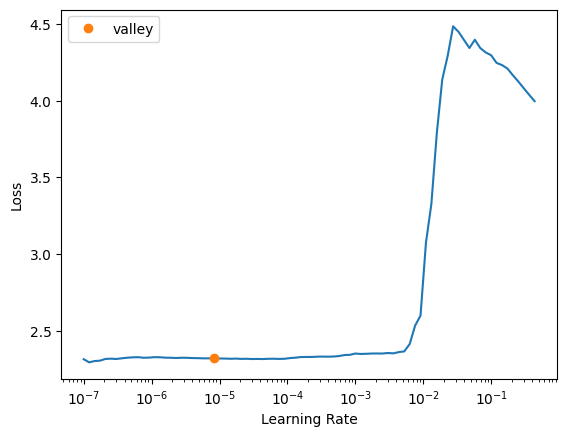

In [197]:
dls = get_dataloaders(train_dataset, val_dataset)
learn = get_learner(cust_model, dls, device=device, cbs=[BatchStatsCallback(every_n=300)])

learn.lr_find()

In [198]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.695406,1.695760,0.433350,0.815651,00:57
1,1.356676,1.416260,0.543500,0.874672,00:59
2,1.103418,1.364431,0.573417,0.886538,00:59
3,0.895772,1.418216,0.580467,0.886827,00:59
4,0.770019,1.459375,0.584417,0.886185,00:59


[Batch 000001] 🔁 Loss: 2.3155 | Acc: 0.1094 | AUC: 0.5619
[Batch 000301] 🔁 Loss: 2.1506 | Acc: 0.2031 | AUC: 0.5723
[Batch 000601] 🔁 Loss: 2.0577 | Acc: 0.3438 | AUC: 0.6183
[Batch 000901] 🔁 Loss: 1.7623 | Acc: 0.3750 | AUC: 0.6621
[Batch 001201] 🔁 Loss: 1.8105 | Acc: 0.3438 | AUC: 0.6996
[Batch 000001] 🔁 Loss: 1.4450 | Acc: 0.4844 | AUC: 0.8691
[Batch 000301] 🔁 Loss: 1.5846 | Acc: 0.4844 | AUC: 0.8460
[Batch 000601] 🔁 Loss: 1.4780 | Acc: 0.5469 | AUC: 0.8535
[Batch 000901] 🔁 Loss: 1.2438 | Acc: 0.6250 | AUC: 0.8587
[Batch 001201] 🔁 Loss: 1.3938 | Acc: 0.5469 | AUC: 0.8639
[Batch 000001] 🔁 Loss: 1.1307 | Acc: 0.6250 | AUC: 0.9317
[Batch 000301] 🔁 Loss: 0.8295 | Acc: 0.7969 | AUC: 0.9135
[Batch 000601] 🔁 Loss: 0.9775 | Acc: 0.6250 | AUC: 0.9148
[Batch 000901] 🔁 Loss: 1.0792 | Acc: 0.6406 | AUC: 0.9168
[Batch 001201] 🔁 Loss: 1.1316 | Acc: 0.5625 | AUC: 0.9184
[Batch 000001] 🔁 Loss: 1.0722 | Acc: 0.6562 | AUC: 0.9450
[Batch 000301] 🔁 Loss: 0.7623 | Acc: 0.7188 | AUC: 0.9446
[Batch 000601]

In [199]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.780841,1.502632,0.575533,0.882182,00:58
1,0.760408,1.571688,0.576150,0.880105,00:59
2,0.666534,1.687636,0.570800,0.876858,00:57
3,0.580661,1.789667,0.575233,0.877178,00:58
4,0.548553,1.823074,0.573800,0.876547,00:59


[Batch 000001] 🔁 Loss: 0.7836 | Acc: 0.7188 | AUC: 0.9632
[Batch 000301] 🔁 Loss: 0.6998 | Acc: 0.7656 | AUC: 0.9644
[Batch 000601] 🔁 Loss: 1.0003 | Acc: 0.6719 | AUC: 0.9642
[Batch 000901] 🔁 Loss: 0.8354 | Acc: 0.6875 | AUC: 0.9640
[Batch 001201] 🔁 Loss: 0.7667 | Acc: 0.6875 | AUC: 0.9635
[Batch 000001] 🔁 Loss: 0.5546 | Acc: 0.8594 | AUC: 0.9787
[Batch 000301] 🔁 Loss: 0.6305 | Acc: 0.7969 | AUC: 0.9651
[Batch 000601] 🔁 Loss: 0.5580 | Acc: 0.8125 | AUC: 0.9640
[Batch 000901] 🔁 Loss: 0.7499 | Acc: 0.7031 | AUC: 0.9640
[Batch 001201] 🔁 Loss: 0.7334 | Acc: 0.7656 | AUC: 0.9637
[Batch 000001] 🔁 Loss: 0.6793 | Acc: 0.7969 | AUC: 0.9744
[Batch 000301] 🔁 Loss: 0.8637 | Acc: 0.6875 | AUC: 0.9721
[Batch 000601] 🔁 Loss: 0.6449 | Acc: 0.7969 | AUC: 0.9721
[Batch 000901] 🔁 Loss: 0.8072 | Acc: 0.7188 | AUC: 0.9715
[Batch 001201] 🔁 Loss: 0.8571 | Acc: 0.7500 | AUC: 0.9713
[Batch 000001] 🔁 Loss: 0.6022 | Acc: 0.8125 | AUC: 0.9760
[Batch 000301] 🔁 Loss: 0.7065 | Acc: 0.7812 | AUC: 0.9785
[Batch 000601]

In [207]:
def evaluate_model(model, dataloader, device, class_names=None):
    """
    Evaluate YahooTextClassifier model: accuracy, macro AUC, and per-class ROC curves.

    Args:
        model: Trained YahooTextClassifier model.
        dataloader: PyTorch DataLoader returning (input_ids, labels).
        device: torch.device ("cuda" or "cpu").
        class_names: Optional list of class names for plotting.
    """
    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for input_ids, labels in tqdm(dataloader):
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            logits = model(input_ids)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_scores = F.softmax(torch.cat(all_logits), dim=-1).numpy()
    y_pred = np.argmax(y_scores, axis=1)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Macro AUC
    try:
        auc = roc_auc_score(y_true, y_scores, multi_class="ovr", average="macro")
        print(f"Macro AUC (OVR): {auc:.4f}")
    except Exception as e:
        print("Macro AUC could not be computed:", str(e))
        auc = -1.0

    # ROC Curve per class
    y_true_bin = label_binarize(y_true, classes=np.arange(y_scores.shape[1]))

    fig, ax = plt.subplots(figsize=(10, 7))
    for i in range(y_scores.shape[1]):
        try:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
            label = f"Class {i}" if class_names is None else class_names[i]
            class_auc = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
            ax.plot(fpr, tpr, label=f"{label} (AUC = {class_auc:.2f})")
        except ValueError:
            continue  # Skip classes not present in batch

    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves per Class")
    ax.legend(loc="lower right")
    ax.grid(True)
    fig.tight_layout()
    plt.show()



100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


Accuracy: 0.5738
Macro AUC (OVR): 0.8765


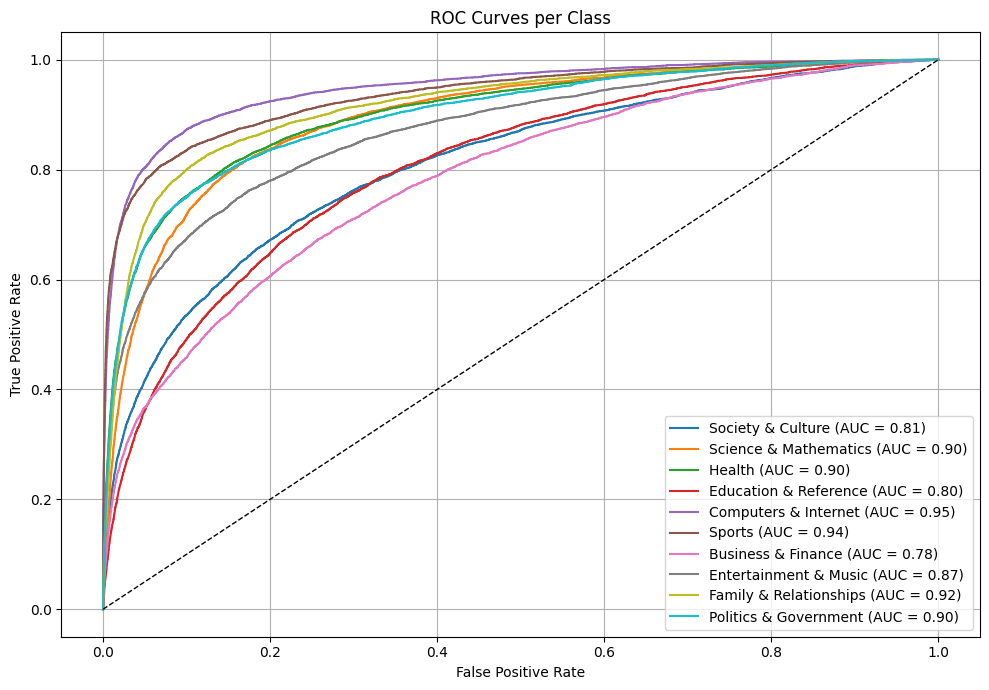

(0.5738, 0.8765475006172838)

In [208]:
evaluate_model(cust_model, dls[1], device, topics)

In [209]:
cust_model

YahooTextClassifier(
  (embedding): Embedding(40000, 128, padding_idx=0)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [203]:
# !rm /kaggle/working/cust_model/yahoo_classifier.*

rm: cannot remove '/kaggle/working/cust_model/yahoo_classifier.*': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [210]:
learn.save("/kaggle/working/cust_model/yahoo_classifier")

Path('/kaggle/working/cust_model/yahoo_classifier.pth')

## Bonus - semantic search

In [217]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 40.9 MB/s eta 0:00:0000:0100:01m


In [218]:
from sentence_transformers import SentenceTransformer
import faiss

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [226]:
ds['test'] = ds['test'].map( lambda x: {"embeddings": sentence_model.encode((x["text"]))}, batched=True, batch_size=10000)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [227]:
ds['test'].with_format('pandas')['embeddings'].apply(np.linalg.norm).round(6).value_counts()
#All have norm = 1

embeddings
1.0    60000
Name: count, dtype: int64

In [229]:
embedding_dim = sentence_model.get_sentence_embedding_dimension()
faiss_index = faiss.IndexFlatL2(embedding_dim)  # L2 is fine for normalized vectors

In [232]:
embeddings = np.array(ds['test']['embeddings']).astype("float32")

# Build the FAISS index
embedding_dim = embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)
faiss_index.add(embeddings)

print(f"FAISS index size: {faiss_index.ntotal}")

FAISS index size: 60000


In [237]:
def search(query: str, top_k: int = 5):
    query_embedding = sentence_model.encode([query], normalize_embeddings=True)
    query_embedding = np.array(query_embedding).astype("float32")
    D, I = faiss_index.search(query_embedding, top_k)
    
    results = []
    for idx, score in zip(I[0], D[0]):
        idx = int(idx) 
        result = ds['test'][idx]
        results.append({
            "text": result["text"],
            "score": float(score)
        })
    return results

In [238]:
query = "How do I get a scholarship to study abroad?"
results = search(query, top_k=5)

for i, r in enumerate(results):
    print(f"{i+1}. (score: {r['score']:.4f}) {r['text']}\n")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1. (score: 0.7940) how can i get a college scholarship in america? 

2. (score: 0.7403) How can I get a scholarships? 

3. (score: 0.7236) How do I get a scholarship to study in Europe? I would like to do a Masters degree in Fashion Marketing asn Merchandising

4. (score: 0.7166) What are the ways to get a full scholarship for a graduate study as a foreigner in the United States? I am a Turkish, political science major, high-honour student.

5. (score: 0.7140) how can i study in abroad? i am from egypt and want to complete ma studies (university) abroad but i need a cheap way



## Save the working dir

In [211]:
!zip -r /kaggle/working/working_dir.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/models/ (stored 0%)
updating: kaggle/working/cust_model/ (stored 0%)
updating: kaggle/working/cust_model/yahoo_classifier.pth

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 10%)
updating: kaggle/working/cust_model/tokenizer.json (deflated 70%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/bert_yahoo_model/ (stored 0%)
updating: kaggle/working/bert_yahoo_model/tokenizer.json (deflated 71%)
updating: kaggle/working/bert_yahoo_model/special_tokens_map.json (deflated 42%)
updating: kaggle/working/bert_yahoo_model/model.safetensors (deflated 7%)
updating: kaggle/working/bert_yahoo_model/tokenizer_config.json (deflated 75%)
updating: kaggle/working/bert_yahoo_model/config.json (deflated 57%)
updating: kaggle/working/bert_yahoo_model/vocab.txt (deflated 53%)
